In [122]:
from abc import ABC, abstractmethod
import re
from sacremoses import MosesTokenizer
import Levenshtein
import spacy
import nltk
import pickle
import urllib
import os
import tarfile
import zipfile
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import numpy as np
from string import punctuation
import matplotlib.pyplot as plt
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
RESOURCES_DIR = Path("C:/Users/Antonio/PycharmProjects/simpleTextCLEF/resources")
DATASETS_PATH = RESOURCES_DIR / "datasets"
WORD_EMBEDDINGS_NAME = "glove.42B.300d"
DUMPS_DIR = RESOURCES_DIR / "DUMPS"

stopwords = set(stopwords.words("english"))

In [2]:
def ControlDivisionByZero(numerator, denominator):
    return numerator / denominator if denominator != 0 else 0


class FeatureAbstract(ABC):

    @abstractmethod
    def get_ratio(self, kwargs):
        pass

    @abstractmethod
    def calculate_ratio(self, simple_text, original_text):
        pass


class Feature(FeatureAbstract):

    def __init__(self, split, target_ratio):
        self.split = split
        self.target_ratio = target_ratio

    def get_ratio(self, kwargs):
        if not 'original_text_preprocessed' in kwargs:
            kwargs['original_text_preprocessed'] = ""

        if self.split == "train":
            simple_text = kwargs.get('simple_text')
            original_text = kwargs.get('original_text')
            result_ratio = self.calculate_ratio(simple_text, original_text)

        elif self.split == "valid" or self.split == "test":
            result_ratio = self.target_ratio
        else:
            raise ValueError("stage value not supported")
        kwargs['original_text_preprocessed'] += f'{self.name}_{result_ratio} '
        return kwargs

    @property
    def name(self):
        class_name = self.__class__.__name__
        name = ""
        for word in re.findall('[A-Z][^A-Z]*', class_name):
            if word: name += word[0]
        if not name: name = class_name
        return name


class WordLengthRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)
        if stage == "train":
            self.tokenizer = MosesTokenizer(lang='en')

    def calculate_ratio(self, simple_text, original_text):
        return round(ControlDivisionByZero(
            len(self.tokenizer.tokenize(simple_text)),
            len(self.tokenizer.tokenize(original_text))), 2)


class CharLengthRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)

    def calculate_ratio(self, simple_text, original_text):
        return round(ControlDivisionByZero(
            len(simple_text),
            len(original_text)), 2)


class LevenshteinRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)

    def calculate_ratio(self, simple_text, original_text):
        return round(Levenshtein.ratio(original_text,
                                       simple_text), 2)


class DependencyTreeDepthRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)
        if stage == "train":
            self.nlp = self.get_spacy_model()

    def get_spacy_model(self):

        model = 'en_core_web_sm'
        if not spacy.util.is_package(model):
            spacy.cli.download(model)
            spacy.cli.link(model, model, force=True, model_path=spacy.util.get_package_path(model))
        return spacy.load(model)

    def calculate_ratio(self, simple_text, original_text):

        result_ratio = round(ControlDivisionByZero(
            self.get_dependency_tree_depth(simple_text),
            self.get_dependency_tree_depth(original_text)), 2)

        return result_ratio

    def get_dependency_tree_depth(self, sentence):

        def get_subtree_depth(node):
            if len(list(node.children)) == 0:
                return 0
            return 1 + max([get_subtree_depth(child) for child in node.children])

        tree_depths = [get_subtree_depth(spacy_sentence.root) for spacy_sentence in self.nlp(sentence).sents]
        if len(tree_depths) == 0:
            return 0
        return max(tree_depths)


class WordRankRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)
        if stage == "train":
            self.tokenizer = MosesTokenizer(lang='en')
            self.word2rank = self._get_word2rank()
            self.length_rank = len(self.word2rank)

    def calculate_ratio(self, simple_text, original_text):

        result_ratio = round(min(ControlDivisionByZero(self.get_lexical_complexity_score(simple_text),
                                                       self.get_lexical_complexity_score(original_text)),
                                 2), 2)

        return result_ratio

    def get_lexical_complexity_score(self, sentence):

        words = self.tokenizer.tokenize(self._remove_stopwords(self._remove_punctuation(sentence)))
        words = [word for word in words if word in self.word2rank]
        if len(words) == 0:
            return np.log(1 + self.length_rank)
        return np.quantile([self._get_rank(word) for word in words], 0.75)

    def _remove_punctuation(self, text):
        return ' '.join([word for word in self.tokenizer.tokenize(text) if not self._is_punctuation(word)])

    def _remove_stopwords(self, text):
        return ' '.join([w for w in self.tokenizer.tokenize(text) if w.lower() not in stopwords])

    def _is_punctuation(self, word):
        return ''.join([char for char in word if char not in punctuation]) == ''

    def _get_rank(self, word):
        rank = self.word2rank.get(word, self.length_rank)
        return np.log(1 + rank)

    def _get_word2rank(self, vocab_size=np.inf):
        model_filepath = DUMPS_DIR / f"{WORD_EMBEDDINGS_NAME}.pk"
        if model_filepath.exists():
            with open(model_filepath, 'rb') as f:
                model = pickle.load(f)
            return model
        else:
            print("Downloading glove.42B.300d ...")
            self._download_glove(model_name='glove.42B.300d', dest_dir=str(DUMPS_DIR))
            print("Preprocessing word2rank...")
            DUMPS_DIR.mkdir(parents=True, exist_ok=True)
            WORD_EMBEDDINGS_PATH = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.txt'
            lines_generator = self._yield_lines(WORD_EMBEDDINGS_PATH)
            word2rank = {}
            # next(lines_generator)
            for i, line in enumerate(lines_generator):
                if i >= vocab_size: break
                word = line.split(' ')[0]
                word2rank[word] = i

            pickle.dump(word2rank, open(model_filepath, 'wb'))
            txt_file = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.txt'
            zip_file = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.zip'
            if txt_file.exists(): txt_file.unlink()
            if zip_file.exists(): zip_file.unlink()
            return word2rank

    def _download_glove(self, model_name, dest_dir):
        url = ''
        if model_name == 'glove.6B':
            url = 'http://nlp.stanford.edu/data/glove.6B.zip'
        elif model_name == 'glove.42B.300d':
            url = 'http://nlp.stanford.edu/data/glove.42B.300d.zip'
        elif model_name == 'glove.840B.300d':
            url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
        elif model_name == 'glove.twitter.27B':
            url = 'http://nlp.stanford.edu/data/glove.twitter.27B.zip',
        else:
            possible_values = ['glove.6B', 'glove.42B.300d', 'glove.840B.300d', 'glove.twitter.27B']
            raise ValueError('Unknown model_name. Possible values are {}'.format(possible_values))
        file_path = self._download_url(url, dest_dir)
        out_filepath = Path(file_path)
        out_filepath = out_filepath.parent / f'{out_filepath.stem}.txt'
        # print(out_filepath, out_filepath.exists())
        if not out_filepath.exists():
            print("Extracting: ", Path(file_path).name)
            self._unzip(file_path, dest_dir)

    def _yield_lines(self, filepath):
        filepath = Path(filepath)
        with filepath.open('r', encoding="latin-1") as f:
            for line in f:
                yield line.rstrip()

    def _download_url(self, url, output_path):
        name = url.split('/')[-1]
        file_path = f'{output_path}/{name}'
        if not Path(file_path).exists():
            with tqdm(unit='B', unit_scale=True, leave=True, miniters=1,
                      desc=name) as t:  # all optional kwargs
                urllib.request.urlretrieve(url, filename=file_path, reporthook=self._download_report_hook(t), data=None)
        return file_path

    def _unzip(self, file_path, dest_dir=None):
        if dest_dir is None:
            dest_dir = os.path.dirname(file_path)
        if file_path.endswith('.zip'):
            with zipfile.ZipFile(file_path, "r") as zip_ref:
                zip_ref.extractall(dest_dir)
        elif file_path.endswith("tar.gz") or file_path.endswith("tgz"):
            tar = tarfile.open(file_path, "r:gz")
            tar.extractall(dest_dir)
            tar.close()
        elif file_path.endswith("tar"):
            tar = tarfile.open(file_path, "r:")
            tar.extractall(dest_dir)
            tar.close()

    def _download_report_hook(self, t):
        last_b = [0]

        def inner(b=1, bsize=1, tsize=None):
            if tsize is not None:
                t.total = tsize
            t.update((b - last_b[0]) * bsize)
            last_b[0] = b

        return inner

In [65]:
sentences_pair = {"simple_text": "esta es la version complicada", "original_text": "esta es la sencilla."}

In [66]:
char = CharLengthRatio("train", 0.8)
sentences_pair = char.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'esta es la version complicada',
 'original_text': 'esta es la sencilla.',
 'original_text_preprocessed': 'CLR_1.45 '}

In [67]:
word_length = WordLengthRatio("train", 0.8)
sentences_pair = word_length.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'esta es la version complicada',
 'original_text': 'esta es la sencilla.',
 'original_text_preprocessed': 'CLR_1.45 WLR_1.0 '}

In [68]:
levenshtein = LevenshteinRatio("train", 0.8)
sentences_pair = levenshtein.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'esta es la version complicada',
 'original_text': 'esta es la sencilla.',
 'original_text_preprocessed': 'CLR_1.45 WLR_1.0 LR_0.65 '}

In [69]:
dependency = DependencyTreeDepthRatio("train", 0.8)
sentences_pair = dependency.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'esta es la version complicada',
 'original_text': 'esta es la sencilla.',
 'original_text_preprocessed': 'CLR_1.45 WLR_1.0 LR_0.65 DTDR_1.0 '}

In [70]:
word_rank = WordRankRatio("train", 0.8)
sentences_pair = word_rank.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'esta es la version complicada',
 'original_text': 'esta es la sencilla.',
 'original_text_preprocessed': 'CLR_1.45 WLR_1.0 LR_0.65 DTDR_1.0 WRR_0.93 '}

Exploring features values from simpleText shared task

In [17]:
SIMPLETEXT_DATASET_PATH = DATASETS_PATH / "simpleText/task 3"
SIMPLETEXT_TRAIN_PATH = SIMPLETEXT_DATASET_PATH / "train"

In [41]:
complex_text = pd.read_csv(SIMPLETEXT_TRAIN_PATH / "simpleText.train.complex", header=None, names=["original_text"])
simple_text = pd.read_csv(SIMPLETEXT_TRAIN_PATH / "simpleText.train.simple", header=None, names=["simple_text"])

In [71]:
sentences_pairs = pd.concat([complex_text, simple_text], axis=1)

In [82]:
results = []
for i,row in sentences_pairs.iterrows():
    sentences_pair = dict(original_text=row['original_text'], simple_text=row['simple_text'])
    sentences_pair = char.get_ratio(sentences_pair)
    sentences_pair = word_length.get_ratio(sentences_pair)
    sentences_pair = levenshtein.get_ratio(sentences_pair)
    sentences_pair = dependency.get_ratio(sentences_pair)
    sentences_pair = word_rank.get_ratio(sentences_pair)
    features = sentences_pair["original_text_preprocessed"].strip().split(" ")
    instance = dict(feature.split("_") for feature in features)
    results.append(instance)

{'original_text': 'In the modern era of automation and robotics, autonomous vehicles are currently the focus of academic and industrial research.', 'simple_text': 'Current academic and industrial research is interested in autonomous vehicles.', 'original_text_preprocessed': 'CLR_0.62 WLR_0.52 LR_0.39 DTDR_0.8 WRR_0.92 '}
{'CLR': '0.62', 'WLR': '0.52', 'LR': '0.39', 'DTDR': '0.8', 'WRR': '0.92'}
{'original_text': 'With the ever increasing number of unmanned aerial vehicles getting involved in activities in the civilian and commercial domain, there is an increased need for autonomy in these systems too.', 'simple_text': 'Drones are increasingly used in the civilian and commercial domain and need to be autonomous.', 'original_text_preprocessed': 'CLR_0.49 WLR_0.5 LR_0.55 DTDR_0.36 WRR_1.07 '}
{'CLR': '0.49', 'WLR': '0.5', 'LR': '0.55', 'DTDR': '0.36', 'WRR': '1.07'}
{'original_text': 'Due to guidelines set by the governments regarding the operation ceiling of civil drones, road-tracking b

In [89]:
len(results)
results_df = pd.DataFrame(results)

In [105]:
results_df

,CLR,WLR,LR,DTDR,WRR
0,0.62,0.52,0.39,0.8,0.92
1,0.49,0.5,0.55,0.36,1.07
2,0.89,0.91,0.79,0.67,0.99
3,0.67,0.57,0.64,0.55,1.03
4,0.72,0.71,0.5,0.38,0.99
...,...,...,...,...,...
643,0.51,0.53,0.67,0.71,1.0
644,0.8,0.84,0.89,0.8,0.96
645,1.03,1.05,0.89,1.2,0.94
646,0.93,1.03,0.88,0.86,0.92


c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


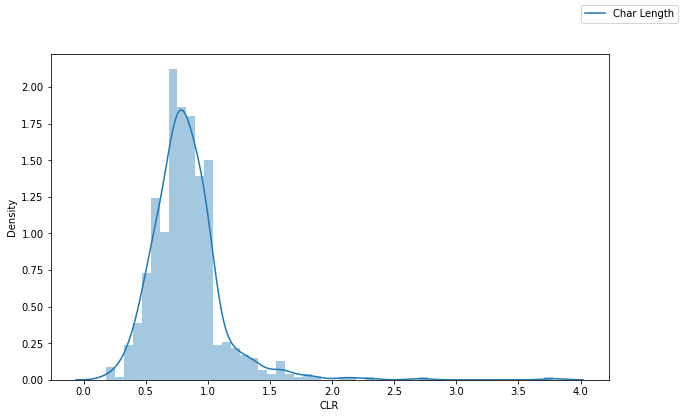

In [128]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results_df["CLR"])
fig.legend(labels=['Char Length'])
plt.show()

c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


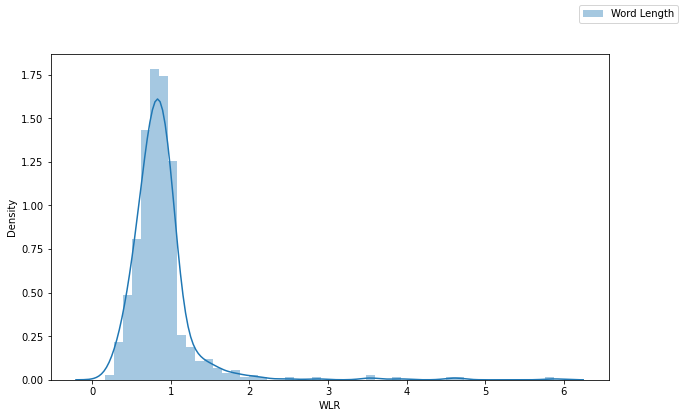

In [127]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results_df["WLR"],label="Word Length")
fig.legend(labels=['Word Length'])
plt.show()

c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


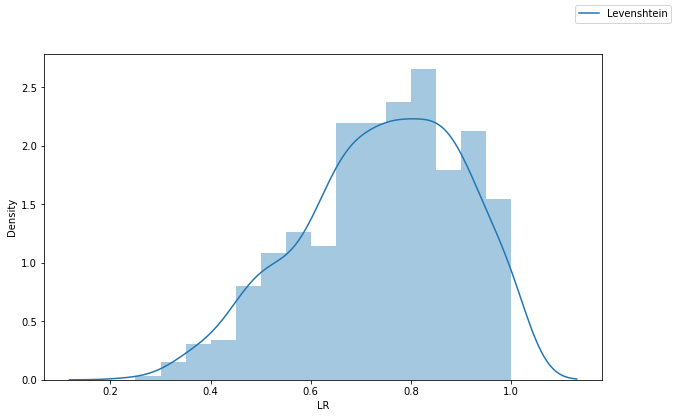

In [126]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results_df["LR"])
fig.legend(labels=['Levenshtein'])
plt.show()

c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


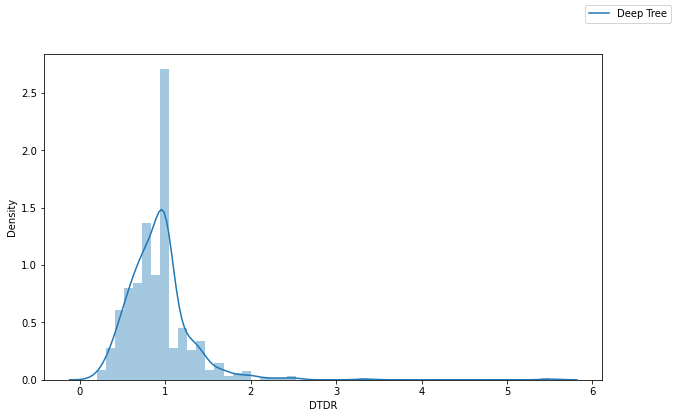

In [125]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results_df["DTDR"])
fig.legend(labels=['Deep Tree'])
plt.show()

c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


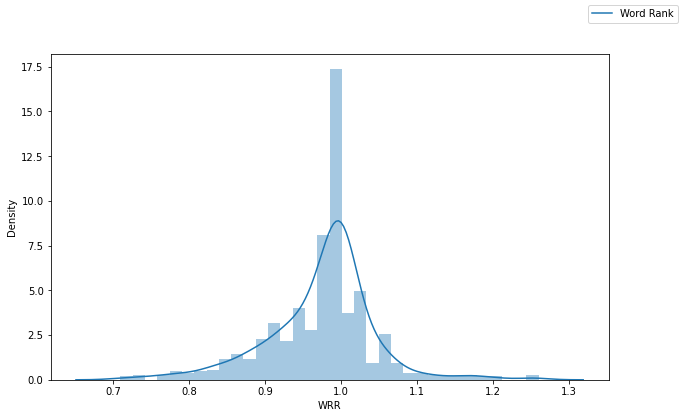

In [124]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results_df["WRR"])
fig.legend(labels=['Word Rank'])
plt.show()